In [1]:
import numpy as np
import xarray as xr
import dask.array as dsar
import xroms as xm
import os.path as op
import gsw
import scipy.interpolate as naiso
import scipy.integrate as intg
import xgcm.grid as xgd
import importlib

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ddir = '../../ROMS_test_data'

In [3]:
eta_s, eta_e = (570, 610)
xi_s, xi_e = (740, 780)

In [4]:
ds_grid = xr.open_dataset(op.join(ddir, 'AS24th_gridfile.nc'))
ds_grid = ds_grid.isel(eta_psi=slice(eta_s,eta_e-1), eta_rho=slice(eta_s,eta_e),
                       eta_u=slice(eta_s,eta_e), eta_v=slice(eta_s,eta_e-1),
                       xi_psi=slice(xi_s,xi_e-1), xi_rho=slice(xi_s,xi_e), 
                       xi_u=slice(xi_s,xi_e-1), xi_v=slice(xi_s,xi_e))

ds_grid

<xarray.Dataset>
Dimensions:    (bath: 0, eta_psi: 39, eta_rho: 40, eta_u: 40, eta_v: 39, one: 1, s_rho: 32, s_w: 33, xi_psi: 39, xi_rho: 40, xi_u: 39, xi_v: 40)
Dimensions without coordinates: bath, eta_psi, eta_rho, eta_u, eta_v, one, s_rho, s_w, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    xl         (one) float64 9.969e+36
    el         (one) float64 9.969e+36
    depthmin   (one) float64 9.969e+36
    depthmax   (one) float64 9.969e+36
    spherical  (one) |S1 b'T'
    angle      (eta_rho, xi_rho) float64 0.0001132 0.0001132 0.0001132 ...
    h          (eta_rho, xi_rho) float64 3.573e+03 3.568e+03 3.563e+03 ...
    hraw       (bath, eta_rho, xi_rho) float64 
    alpha      (eta_rho, xi_rho) float64 9.969e+36 9.969e+36 9.969e+36 ...
    f          (eta_rho, xi_rho) float64 4.527e-05 4.527e-05 4.527e-05 ...
    pm         (eta_rho, xi_rho) float64 0.0002272 0.0002272 0.0002272 ...
    pn         (eta_rho, xi_rho) float64 0.0002272 0.0002272 0.0002272 ...
    dndx       (eta_rho,

In [5]:
zr = ds_grid.z_rho0[::-1]
zw = ds_grid.z_w0
x_r = ds_grid.x_rho
y_r = ds_grid.y_rho
x_v = ds_grid.x_v
y_u = ds_grid.y_u
lon_psi = ds_grid.lon_psi
lat_psi = ds_grid.lat_psi
zr

<xarray.DataArray 'z_rho0' (s_rho: 32, eta_rho: 40, xi_rho: 40)>
array([[[ -2.934587e+00,  -2.933544e+00, ...,  -2.892009e+00,  -2.893163e+00],
        [ -2.933691e+00,  -2.932449e+00, ...,  -2.886988e+00,  -2.887420e+00],
        ..., 
        [ -2.879974e+00,  -2.877673e+00, ...,  -2.820559e+00,  -2.814083e+00],
        [ -2.879505e+00,  -2.877067e+00, ...,  -2.827995e+00,  -2.822435e+00]],

       [[ -8.836683e+00,  -8.833510e+00, ...,  -8.707145e+00,  -8.710655e+00],
        [ -8.833958e+00,  -8.830179e+00, ...,  -8.691871e+00,  -8.693185e+00],
        ..., 
        [ -8.670534e+00,  -8.663537e+00, ...,  -8.489824e+00,  -8.470130e+00],
        [ -8.669107e+00,  -8.661692e+00, ...,  -8.512436e+00,  -8.495528e+00]],

       ..., 
       [[ -2.606720e+03,  -2.603379e+03, ...,  -2.471098e+03,  -2.474752e+03],
        [ -2.603851e+03,  -2.599873e+03, ...,  -2.455215e+03,  -2.456581e+03],
        ..., 
        [ -2.433068e+03,  -2.425816e+03, ...,  -2.247523e+03,  -2.227537e+03],
       

In [6]:
H = zw[-1]

In [7]:
ds = xr.open_dataset(op.join(ddir, 'roms_avg_M01.nc'))
ds = xm.set_coords(ds)

In [8]:
ds = ds.isel(eta_rho=slice(eta_s,eta_e),eta_v=slice(eta_s,eta_e-1),
             xi_rho=slice(xi_s,xi_e), xi_u=slice(xi_s,xi_e-1))
ds

<xarray.Dataset>
Dimensions:     (auxil: 4, eta_rho: 40, eta_v: 39, s_rho: 32, s_w: 33, time: 10, xi_rho: 40, xi_u: 39)
Coordinates:
    spherical   |S1 b'T'
    xl          float32 9.969e+36
    el          float32 9.969e+36
  * xi_rho      (xi_rho) float32 741.0 742.0 743.0 744.0 745.0 746.0 747.0 ...
  * xi_u        (xi_u) float32 741.5 742.5 743.5 744.5 745.5 746.5 747.5 ...
  * eta_rho     (eta_rho) float32 571.0 572.0 573.0 574.0 575.0 576.0 577.0 ...
  * eta_v       (eta_v) float32 571.5 572.5 573.5 574.5 575.5 576.5 577.5 ...
    Vtransform  float32 2.0
  * s_rho       (s_rho) float32 -0.984375 -0.953125 -0.921875 -0.890625 ...
  * s_w         (s_w) float32 -1.0 -0.96875 -0.9375 -0.90625 -0.875 -0.84375 ...
    sc_r        (s_rho) float32 -0.984375 -0.953125 -0.921875 -0.890625 ...
    sc_w        (s_w) float32 -1.0 -0.96875 -0.9375 -0.90625 -0.875 -0.84375 ...
    Cs_r        (s_rho) float32 -0.896205 -0.719762 -0.577987 -0.464067 ...
    Cs_w        (s_w) float32 -1.0 -0.8031

In [9]:
grid = xgd.Grid(ds, periodic=False)
grid

<xgcm.Grid>
X Axis (not periodic):
  * center   xi_rho (40) --> inner
  * inner    xi_u (39) --> center
Z Axis (not periodic):
  * center   s_rho (32) --> outer
  * outer    s_w (33) --> center
T Axis (not periodic):
  * center   time (10)
Y Axis (not periodic):
  * center   eta_rho (40) --> inner
  * inner    eta_v (39) --> center

In [10]:
w = ds.w[::2]
# w = w.chunk({'eta_rho':1, 'xi_rho':1})
w

<xarray.DataArray 'w' (time: 5, s_rho: 32, eta_rho: 40, xi_rho: 40)>
[256000 values with dtype=float32]
Coordinates:
    spherical   |S1 b'T'
    xl          float64 9.969e+36
    el          float64 9.969e+36
  * xi_rho      (xi_rho) float32 741.0 742.0 743.0 744.0 745.0 746.0 747.0 ...
  * eta_rho     (eta_rho) float32 571.0 572.0 573.0 574.0 575.0 576.0 577.0 ...
    Vtransform  float64 2.0
  * s_rho       (s_rho) float32 -0.984375 -0.953125 -0.921875 -0.890625 ...
    sc_r        (s_rho) float32 -0.984375 -0.953125 -0.921875 -0.890625 ...
    Cs_r        (s_rho) float32 -0.896205 -0.719762 -0.577987 -0.464067 ...
    hc          float64 150.0
    h           (eta_rho, xi_rho) float32 3572.54 3567.9 3562.66 3557.4 ...
    f           (eta_rho, xi_rho) float32 4.52654e-05 4.52654e-05 ...
    pm          (eta_rho, xi_rho) float32 0.000227243 0.000227243 ...
    pn          (eta_rho, xi_rho) float32 0.000227218 0.000227218 ...
    lon_rho     (eta_rho, xi_rho) float32 63.8833 63.925 63

In [11]:
N = w.shape
zi = np.array([0,1,3,5,7,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,
            95,100,110,115,120,125,130,135,140,145,150,155,160,165,170,175,
            180,185,190,195,200,210,220,240,260,280,300,320,340,360,380,
            400,450,500,550,600,650,700,750,800,850,900,950,1000,1100,1200,
            1300,1400,1500,1700,2000,2500,3000,3500,4000,4500], dtype=float
             )
nzi = len(zi)
wdim = w.dims

In [20]:
# zzi = zi[:,np.newaxis,np.newaxis] * np.ones((40,40))
# zzi.shape

(78, 40, 40)

In [12]:
# dai = np.empty((N[0],nzi,N[-2],N[-1]))
# dim = [wdim[0],'z',wdim[-2],wdim[-1]]
# coord = {wdim[0]:w.coords[wdim[0]],
#         'z':-zi, wdim[-2]:w.coords[wdim[-2]],
#         wdim[-1]:w.coords[wdim[-1]]
#         }
# dai = xr.DataArray(dai, dims=dim, coords=coord).chunk({'time':1, 'eta_rho':20, 'xi_rho':20})
# dai

In [12]:
def _interpn(y,x,xnew):
    """
    Interpolates and flips the vertical coordinate so as
    the bottom layer is at the top of the array in sigma coordinates.
    """
    f = naiso.interp1d(x,y,
                    fill_value='extrapolate')
    return f(xnew)

def _interp_wrap(interp_func):
    """
    Wrapper function for `xroms._interpolate1D`.
    """
    def func(a, b, bnew, axes=None):
        # if a.ndim > 4 or len(axes) > 3:
        #     raise ValueError("Data has too many dimensions "
        #                     "and/or too many axes to detrend over.")
        if axes is None:
            axes = tuple(range(a.ndim))
        else:
            if len(set(axes)) < len(axes):
                raise ValueError("Duplicate axes are not allowed.")

        if len(axes)>1:
            raise NotImplementedError("Interpolation over multiple "
                                    "axes is not implemented yet.")

        for each_axis in axes:
            if len(a.chunks[each_axis]) != 1:
                raise ValueError('The axis along the interpolation applied '
                                'cannot be chunked.')

        if a.ndim == 1:
            return dsar.map_blocks(interp_func, a, b, bnew,
                                   chunks=a.chunks, dtype=a.dtype
                                  )
        else:
            for each_axis in range(a.ndim):
                if each_axis not in axes:
                    if len(a.chunks[each_axis]) != a.shape[each_axis]:
                        raise ValueError("The axes other than ones to "
                                        "interpolate should have "
                                        "a chunk length of 1.")
            return dsar.map_blocks(interp_func, a, b, bnew,
                                   chunks=a.chunks, dtype=a.dtype
                                  )

    return func

def _apply_interp(da, z, znew, axes):
    """Wrapper function for applying interpolation"""
    if da.chunks:
        func = _interp_wrap(_interpn)
        da = xr.DataArray(func(da.data, z, znew, axes=axes),
                        dims=da.dims, coords=da.coords)
    else:
        if da.ndim == 1:
            da = xr.DataArray(_interpn(da, z, znew),
                            dims=da.dims, coords=da.coords)
        else:
            # da = detrendn(da, axes=axis_num)
        # else:
            raise ValueError("Data should be dask array "
                            "for multidimensional data.")

    return da

In [13]:
def sig2z(da, grid, zr, zi, nvar=None, axes=None,
        dim=None, coord=None):
    """
    Interpolate variables on \sigma coordinates onto z coordinates.

    Parameters
    ----------
    da : `dask.array`
        The data on sigma coordinates to be interpolated
    grid : `xgcm.object`
        The grid information of the data set.
    zr : `numpy.array`
        The depths corresponding to sigma layers
    zi : `numpy.array`
        The depths which to interpolate the data on
    nvar : str (optional)
        Name of the variable. Only necessary when the variable is
        horizontal velocity.

    Returns
    -------
    dai : `dask.array`
        The data interpolated onto a spatial uniform z coordinate
    """

    if np.diff(zi)[0] < 0. or zi.max() <= 0.:
        raise ValueError("The values in `zi` should be postive and increasing.")
    if np.any(np.absolute(zr[0]) > np.absolute(zr[-1])):
        raise ValueError("`zr` should have the deepest depth at the last index")
    if zr.shape != da.shape[-3:]:
        raise ValueError("`zr` should have the same "
                        "spatial dimensions as `da`.")

    if dim == None:
        dim = da.dims
    if coord == None:
        coord = da.coords
    # N = da.shape
    # nzi = len(zi)
    # if len(N) == 4:
    #     dai = np.empty((N[0],nzi,N[-2],N[-1]))
    #     # dim = [dimd[0],'z',dimd[-2],dimd[-1]]
    #     # coord = {dimd[0]:da.coords[dimd[0]],
    #     #         'z':-zi, dimd[-2]:da.coords[dimd[-2]],
    #     #         dimd[-1]:da.coords[dimd[-1]]
    #     #         }
    # elif len(N) == 3:
    #     dai = np.empty((nzi,N[-2],N[-1]))
    #     # dim = ['z',dimd[-2],dimd[-1]]
    #     # coord = {'z':-zi, dimd[-2]:da.coords[dimd[-2]],
    #     #         dimd[-1]:da.coords[dimd[-1]]
    #     #         }
    # else:
    #     raise ValueError("The data should at least have three dimensions")
    # dai[:] = np.nan

#     zi = -zi[::-1] # ROMS has deepest level at index=0
    zi = -zi

    if nvar=='u':  # u variables
        zl = grid.interp(zr, 'X', boundary='extend')
        # zl = .5*(np.roll(np.roll(zr, -1, axis=-1), -1, axis=-2)
        #          + np.roll(zr, -1, axis=-2)
        #         )
    elif nvar=='v': # v variables
        zl = grid.interp(zr, 'Y', boundary='extend')
        # zl = .5*(np.roll(zr, -1, axis=-1)
        #          + np.roll(np.roll(zr, -1, axis=-2), -1, axis=-1)
        #         )
    else:
        zl = zr

    dai = _apply_interp(da, zl, zi, axes)
    # for i in range(N[-1]):
    #     for j in range(N[-2]):
    #         # only bother for sufficiently deep regions
    #         if zl[:,j,i].min() < -1e2:
    #             # only interp on z above topo
    #             ind = np.argwhere(zi >= zl[:,j,i].min())
    #             if len(N) == 4:
    #                 for s in range(N[0]):
    #                     dai[s,:len(ind),j,i] = _interpolate(zl[:,j,i],
    #                                                         da[s,:,j,i].values,
    #                                                         zi[int(ind[0]):])
    #             else:
    #                 dai[:len(ind),j,i] = _interpolate(zl[:,j,i],
    #                                                  da[:,j,i].values,
    #                                                  zi[int(ind[0]):])
    return dai
#     return xr.DataArray(dai.data, dims=dim, coords=coord)

In [14]:
for each_axis in (1,):
    if len(w.chunk({'time':1,'eta_rho':1,'xi_rho':1}).chunks[each_axis]) != 1:
        raise ValueError('The axis along the interpolation applied '
                        'cannot be chunked.')

In [19]:
# len(w.chunk({'time':1,'eta_rho':1,'xi_rho':1}).chunks[2])
zr.chunk({'eta_rho':1,'xi_rho':1}).data

dask.array<xarray-<this-array>, shape=(32, 40, 40), dtype=float64, chunksize=(32, 1, 1)>

In [15]:
test = sig2z(w.chunk({'time':1,'eta_rho':1,'xi_rho':1}), grid, zr.chunk({'eta_rho':1,'xi_rho':1}).data, zi, 
             axes=(1,),
             dim=[wdim[0],'z',wdim[-2],wdim[-1]], 
             coord={wdim[0]:w.coords[wdim[0]],'z':-zi,
                    wdim[-2]:w.coords[wdim[-2]],wdim[-1]:w.coords[wdim[-1]]}
            )
test.compute()

ValueError: x and y arrays must be equal in length along interpolation axis.

In [25]:
test[0]

True

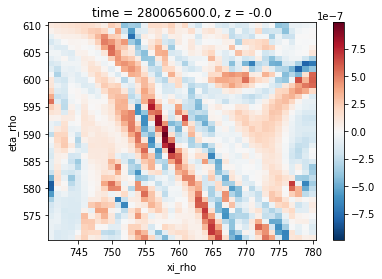

In [20]:
test[0,0].plot()

In [40]:
# print(w[0], zr.chunk({'eta_rho':20, 'xi_rho':20}))
print(dai[0].chunks)

((78,), (20, 20), (20, 20))


In [42]:
test = dsar.map_blocks(sig2z, w[0].chunk({'eta_rho':20, 'xi_rho':20}).data, 
                       zr.chunk({'eta_rho':20,'xi_rho':20}).data, zi, 
                       dim=dim, coord=coord,
                       chunks=dai[0].chunks, dtype=dai.dtype
                      )
test

dask.array<sig2z, shape=(78, 40, 40), dtype=float64, chunksize=(78, 20, 20)>

In [43]:
test.compute()

RuntimeError: Resource temporarily unavailable

In [40]:
xr.DataArray(test.compute())[0].plot()

RuntimeError: Resource temporarily unavailable

In [21]:
def _wrap(sig2z_func):
    """
    Wrapper function for `xrft.detrendn`.
    """
    def func(y, x, ynew, xnew, axes=None):
        if y.ndim > 4 or len(axes) > 1:
            raise ValueError("Data has too many dimensions "
                             "and/or too many axes to regrid over.")
        if axes is None:
            axes = tuple(range(y.ndim))
        else:
            if len(set(axes)) < len(axes):
                raise ValueError("Duplicate axes are not allowed.")

        for each_axis in axes:
            if len(y.chunks[each_axis]) != 1:
                raise ValueError('The axis along the regriding is upon '
                                 'cannot be chunked.')

        if y.ndim == 1:
            return dsar.map_blocks(_interpolate, y, x, xnew,
                                   chunks=ynew.chunks, dtype=ynew.dtype
                                  )
        else:
            for each_axis in range(y.ndim):
                if each_axis not in axes:
                    if len(y.chunks[each_axis]) != y.shape[each_axis]:
                        raise ValueError("The axes other than ones to regrid "
                                         "over should have a chunk length of 1.")
            return dsar.map_blocks(sig2z_func, y, x, xnew,
                                   chunks=ynew.chunks, dtype=ynew.dtype
                                  )

    return func

In [22]:
def _apply(da, z, dnew, znew, axis_num):
    """Wrapper function for applying detrending"""
    if da.chunks:
        if type(z) != xr.DataArray:
            raise ValueError("`z` should be a `dask.array`")
        func = _wrap(sig2z)
        da = xr.DataArray(func(da.data, z.data, dnew, znew, axes=axis_num),
                        dims=dnew.dims, coords=dnew.coords)
    else:
        if da.ndim == 1:
            da = xr.DataArray(_interpolate(da, z, znew),
                            dims=da.dims, coords=da.coords)
        else:
            da = sig2z(da, z, znew, axes=axis_num)
        # else:
        #     raise ValueError("Data should be dask array.")

    return da

In [36]:
for t in range(10):
    w_on_z = _apply(w[t].data, zr.chunk({'eta_rho':1, 'xi_rho':1}).data, dai[t], zi, [0])
    print(w_on_z)
    dai[t] = w_on_z.compute()

RuntimeError: Resource temporarily unavailable